In [5]:
# -*- coding: utf-8 -*-

import os,cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K
#K.set_image_dim_ordering('th')

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam

import pandas as pd
import csv
from os.path import splitext
import os.path

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)

PATH = os.getcwd()
img_rows=128
img_cols=128
num_channel=1
num_epoch=20
styleFilePath = os.path.abspath('./CNN-image-dataset-all-label.csv')
print(styleFilePath)
styledf=pd.read_csv(styleFilePath)

styledf = styledf.iloc[np.random.permutation(len(styledf))]

C:\Users\rohit\Downloads\MSc_Project_19\CNN-image-dataset-all-label.csv


In [6]:
top_words = 5000
X_train, X_test, y_train, y_test = train_test_split(styledf['productDisplayName'], styledf['LABEL'], test_size=0.2, random_state=2)

In [7]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
df = styledf.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. 
    #substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text.
    #substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['productDisplayName'] = df['productDisplayName'].apply(clean_text)
df['productDisplayName'] = df['productDisplayName'].str.replace('\d+', '')
df['productDisplayName']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rohit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                         highlander men check grey shirt
1                          skechers men berra brown shoes
2                                   adidas men red tshirt
3                  deni yo men washed blue slim fit jeans
4                           nike women purple polo tshirt
5                      skechers mens lifestyle black shoe
6                              id mens graphic black shoe
7                        locomotive men washed blue jeans
8                   skechers mens sparta black brown shoe
9              classic polo men stripes black polo tshirt
10                         ganuchi men casual beige shoes
11       adidas originals women concord round beige shoes
12                               puma men even keel shoes
13                     lotto mens calcetto black red shoe
14                       levis men work western red shirt
15                 united colors benetton men white shirt
16                          vans men half cab black shoes
17            

In [8]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 250
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['productDisplayName'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1192 unique tokens.


In [9]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['productDisplayName'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3552, 250)


# Converting categorical labels to numbers.

In [10]:

from keras.utils import to_categorical
Y = to_categorical(np.array(df.iloc[:, 1]))
print(Y)
print('Shape of label tensor:', Y.shape)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
Shape of label tensor: (3552, 3)


# Train test split.

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2841, 250) (2841, 3)
(711, 250) (711, 3)


In [15]:
import time
from keras.callbacks import EarlyStopping  
from keras.layers.core import Dense, SpatialDropout1D
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64
start_time = time.time()
history = model.fit(X_train, Y_train,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=7, min_delta=0.0001)])

print("--- %s seconds ---" % (time.time() - start_time))
rnn_run_time = time.time() - start_time


Train on 2556 samples, validate on 285 samples
Epoch 1/5
2556/2556 [==============================] - 20s 8ms/step - loss: 0.8618 - acc: 0.7152 - val_loss: 0.5258 - val_acc: 0.8386
Epoch 2/5
2556/2556 [==============================] - 18s 7ms/step - loss: 0.2768 - acc: 0.9100 - val_loss: 0.1177 - val_acc: 0.9930
Epoch 3/5
2556/2556 [==============================] - 17s 7ms/step - loss: 0.0518 - acc: 0.9949 - val_loss: 0.0203 - val_acc: 0.9965
Epoch 4/5
2556/2556 [==============================] - 17s 7ms/step - loss: 0.0154 - acc: 0.9977 - val_loss: 0.0116 - val_acc: 0.9965
Epoch 5/5
2556/2556 [==============================] - 17s 7ms/step - loss: 0.0091 - acc: 0.9980 - val_loss: 0.0069 - val_acc: 1.0000
--- 91.14141035079956 seconds ---


In [16]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

711/711 [==============================] - 2s 3ms/step
Test set
  Loss: 0.010
  Accuracy: 0.997


5
711


<Figure size 504x360 with 0 Axes>

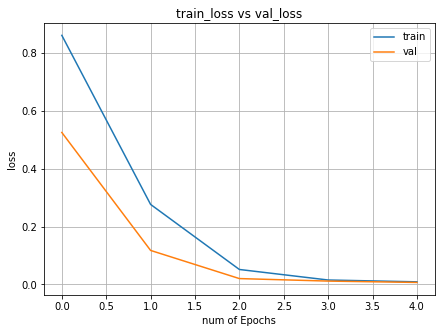

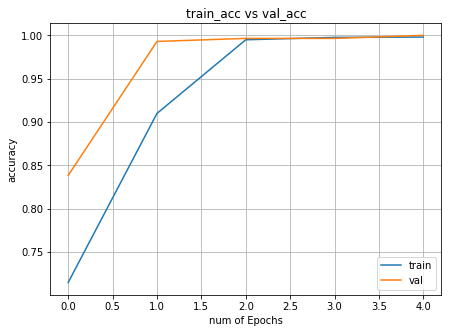

<Figure size 504x360 with 0 Axes>

In [17]:
# visualizing losses and accuracy
hist = history
train_loss=history.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(epochs)
print(len(train_loss))
plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
#plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
#plt.style.use(['classic']

predictions = model.predict(X_test)
print(len(predictions))
#print(y_test.shape)
#print(predictions[:,0].shape)
#print(predictions[:,0])
plt.figure(3,figsize=(7,5))
#plt.scatter(y_test,predictions[:,0])

In [27]:
Y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

## len(model.predict_proba(X_test))

In [28]:
print(X_test)
pred_class = model.predict_classes(X_test)
pred_label = []
for p in pred_class:
    if p == 0:
        pred_label.append("Shirts")
    if p == 1:
        pred_label.append("Shoes")
    if p == 2:
        pred_label.append("Trouser")    

[[  0   0   0 ...  67 114   2]
 [  0   0   0 ...  30   6  11]
 [  0   0   0 ...  29   5  15]
 ...
 [  0   0   0 ...  32  28   9]
 [  0   0   0 ...   3  38   2]
 [  0   0   0 ...  14   6   2]]


In [29]:
#Create data frame to save the results
prob = []
prob_rfc = pd.DataFrame(prob, columns=['ID','LABEL','CNN','RNN','productDisplayName'])
prob_rfc['RNN'] = pred_class
prob_rfc['ID'] = df['ID']
prob_rfc['LABEL'] = df['LABEL']
prob_rfc['productDisplayName'] = df['productDisplayName']

#Rearrange the order of column in the result file.
prob_rfc = prob_rfc[['ID','LABEL','CNN','RNN','productDisplayName']]

#Remove file if already exist 
if os.path.exists("outputCNNRNN.csv"):
    os.remove("outputCNNRNN.csv")
#Generate csv file for results
prob_rfc.to_csv(os.path.join('outputCNNRNN.csv'), index=False)

In [30]:
cnn_prob = model.predict_proba(X_test)

In [31]:
# Saving and loading model and weights
from keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
model_json = model.to_json()
with open("rnnmodel.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("rnnmodel.h5")
print("Saved model to disk")

Saved model to disk


In [22]:
model.predict_proba(X_test)
# get the predictions for the test data
predicted_classes = model.predict_classes(X_test)
print(len(predicted_classes))
# get the indices to be plotted

y_true = df.iloc[2841:, 1].values
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]
print(len(correct))
print(len(incorrect))

711
273
438


In [19]:
print(len(y_test))
print(len(predicted_classes))
classes = {0: 'Shirts', 
           1: 'Shoes', 
           2: 'Trouser'}

class_names = ['Shirts','Shoes','Trouser']
import itertools
from sklearn.metrics import confusion_matrix, classification_report
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
cnf_matrix = confusion_matrix(df.iloc[1500:, 1], predicted_classes)
plot_confusion_matrix(cnf_matrix, classes = class_names)

711


NameError: name 'predicted_classes' is not defined

In [34]:
pred_accuracy = (len(correct)/5000) * 100

print("--- %s is the Prediction Accuracy ---" % (pred_accuracy))

--- 62.4 is the Prediction Accuracy ---


In [35]:
rnn_run_time

335.2088420391083